**PROBLEM 5: DBSCAN on toy-neighborhood data**

You are to cluster, and visualize, a small dataset using DBSCAN epsilon = 7.5, MinPts = 3). You have been provided a file, dbscan.csv, that has the following columns for each point in the dataset:

cluster originally empty, provided for your convenience pt a unique id for each data point

x point x-coordinate

y point y-coordinate

num neighbors number of neighbors, according to the coordinates above neighbors the id’s of all neighbors within

As you can see, a tedious O(n^2) portion of the work has been done for you. Your job is to execute, point-by-point, the DBSCAN algorithm, logging your work.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

In [2]:
# Loading data
url = 'https://www.ccs.neu.edu/home/vip/teach/DMcourse/2_cluster_EM_mixt/HW2/dbscan.csv'
data = pd.read_csv(url)  # Read into a DataFrame
print(data.head())  # Preview first few rows

# Convert to NumPy array (excluding non-numeric columns)
numeric_data = data.select_dtypes(include=['number']).to_numpy()
print(f"Numeric data shape: {numeric_data.shape}")

   cluster  pt          x          y  num_neighbors neighbors
0      NaN   0  51.418089  13.593610              2      0,27
1      NaN   1  39.132318  -4.419204              3   1,40,75
2      NaN   2  47.807515 -25.822561              1         2
3      NaN   3  27.699703  53.434193              1         3
4      NaN   4  39.860995   5.676871              3   4,56,75
Numeric data shape: (80, 5)


In [3]:
# Initialize DBSCAN Parameters
epsilon = 7.5
minPts = 3

# Define Cluster Labels
cluster_assignments = {}  # Dictionary to track cluster assignments

# Cluster tracking
current_cluster = 0
noise = 0

# Convert NaN cluster values to None (unvisited)
data['cluster'] = None

In [4]:
# Function to expand a cluster recursively
def expand_cluster(point_index, cluster_id):
    """
    Expands a given cluster by checking the neighbors and
    adding core points to the cluster.
    """
    neighbors_to_visit = data.loc[point_index, 'neighbors']

    if isinstance(neighbors_to_visit, str):
        neighbors_to_visit = list(map(int, neighbors_to_visit.split(',')))  # Convert string of neighbors into a list

    while neighbors_to_visit:
        neighbor_id = neighbors_to_visit.pop()  # Get a neighbor
        neighbor_index = data.index[data['pt'] == neighbor_id].tolist()[0]  # Get the row index

        if data.at[neighbor_index, 'cluster'] is None:  # If not yet assigned
            data.at[neighbor_index, 'cluster'] = cluster_id  # Assign to cluster

            # If neighbor is also a core point, expand further
            num_neighbors = data.at[neighbor_index, 'num_neighbors']
            if num_neighbors >= minPts:
                more_neighbors = data.at[neighbor_index, 'neighbors']
                if isinstance(more_neighbors, str):
                    more_neighbors = list(map(int, more_neighbors.split(',')))
                    neighbors_to_visit.extend(more_neighbors)  # Expand cluster

In [5]:
# DBSCAN Algorithm
for index, row in data.iterrows():
    if data.at[index, 'cluster'] is not None:  # Skip if already assigned
        continue

    num_neighbors = row['num_neighbors']

    if num_neighbors < minPts:
        data.at[index, 'cluster'] = noise  # Mark as noise (outlier)
    else:
        current_cluster += 1  # Create a new cluster
        data.at[index, 'cluster'] = current_cluster  # Assign cluster
        expand_cluster(index, current_cluster)  # Expand cluster

# Display the final clustered data
display(data)

,cluster,pt,x,y,num_neighbors,neighbors
0,0,0,51.418089,13.593610,2,"0,27"
1,1,1,39.132318,-4.419204,3,"1,40,75"
2,0,2,47.807515,-25.822561,1,2
3,0,3,27.699703,53.434193,1,3
4,1,4,39.860995,5.676871,3,"4,56,75"
...,...,...,...,...,...,...
75,1,75,39.659047,0.230178,3,"1,4,75"
76,2,76,26.366491,8.798826,3,"21,49,76"
77,0,77,-36.184060,44.292045,2,"55,77"
78,3,78,44.012085,37.729478,3,"9,33,78"


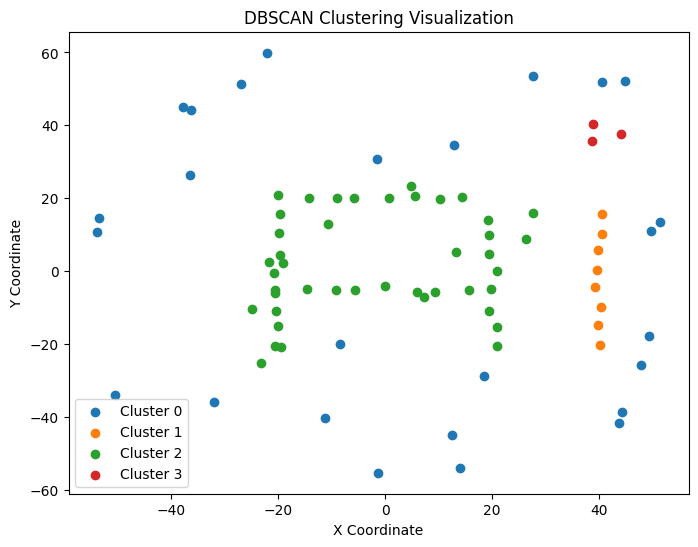

In [6]:
# Scatter plot of clusters
plt.figure(figsize=(8,6))

# Plot each cluster with a different color
for cluster_id in data['cluster'].unique():
    cluster_points = data[data['cluster'] == cluster_id]
    plt.scatter(cluster_points['x'], cluster_points['y'], label=f"Cluster {cluster_id}")

# Formatting
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('DBSCAN Clustering Visualization')
plt.legend()
plt.show()

**PROBLEM 6: DBSCAN on toy raw data**

Three toy 2D datasets are provided (or they can be obtained easily with scikit learn) circles; blobs, and moons. Run your own implementation of DBSCAN on these, in two phases.


In [10]:
# Start with generating our datasets
from sklearn.datasets import make_circles, make_blobs, make_moons

# Synthetic datasets
datasets = {
    'Circles': make_circles(n_samples=300, noise=0.05, factor=0.5, random_state=42),
    'Blobs': make_blobs(n_samples=300, centers=4, cluster_std=1.5, random_state=42),
    'Moons': make_moons(n_samples=300, noise=0.05, random_state=42)
}

In [11]:
# DBSCAN Parameters for each dataset
dbscan_params = {
    "Circles": {"epsilon": 0.2, "minPts": 5},
    "Blobs": {"epsilon": 1.5, "minPts": 6},
    "Moons": {"epsilon": 0.2, "minPts": 5},
}

# DBSCAN Algorithm
def dbscan(X, epsilon, minPts):
    """
    DBSCAN Implementation for clustering 2D points.
    """
    clusters = np.full(X.shape[0], -1)  # Initialize all points as noise (-1)
    cluster_id = 0

    # Function to expand a cluster
    def expand_cluster(point_idx, cluster_id):
        neighbors = region_query(point_idx)
        if len(neighbors) < minPts:
            return False
        else:
            clusters[point_idx] = cluster_id
            queue = neighbors.copy()
            while queue:
                neighbor_idx = queue.pop()
                if clusters[neighbor_idx] == -1:  # Only update if still noise
                    clusters[neighbor_idx] = cluster_id  # Assign to cluster
                    new_neighbors = region_query(neighbor_idx)
                    if len(new_neighbors) >= minPts:
                        queue.extend(new_neighbors)  # Expand the cluster
            return True

    # Function to find neighbors within epsilon radius
    def region_query(point_idx):
        distances = np.linalg.norm(X - X[point_idx], axis=1)
        return np.where(distances <= epsilon)[0].tolist()

    # Process each point
    for i in range(X.shape[0]):
        if clusters[i] != -1:
            continue
        if expand_cluster(i, cluster_id):
            cluster_id += 1

    return np.array(clusters)

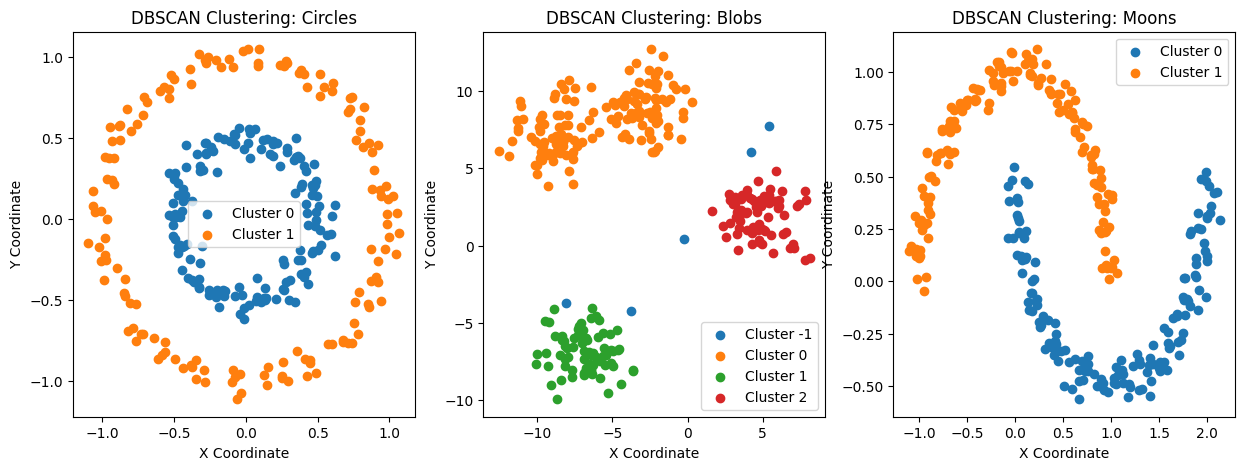

In [12]:
# Apply DBSCAN to Each Dataset
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (name, (X, _)) in enumerate(datasets.items()):
    params = dbscan_params[name]
    labels = dbscan(X, params["epsilon"], params["minPts"])
    unique_clusters = np.unique(labels)

    # Plot Clusters
    plt.subplot(1, 3, i + 1)
    for cluster in unique_clusters:
        cluster_points = X[labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")

    # Plot Formatting
    plt.title(f"DBSCAN Clustering: {name}")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()

plt.show()

**PROBLEM 7: DBSCAN on real data**

Run the DBSCAN algorithm on the 20NG dataset, and on the FASHION dataset, and the HouseHold dataset (see papers), and evaluate results. You need to implement both phases (1) neighborhoods creation, (2) DBSCAN.

Explain why/when it works, and speculate why/when not. You need to trial and error for parameters epsilon and MinPts

EXTRA CREDIT: Using class labels (cheating), try to remove/add points in curate the set for better DBSCAN runs

Note on TF-IDF Vectorization: Term Frequency-Inverse Document Frequency is a text representation technique that evaluates how importat a word is to a document relative to a corpus.

Term Frequency (TF) = (word count in doc) / (total words in doc) - measures local importance of a word

Inverse document frequency (IDF) = log(total docs / docs containing word) - penalizes words common across many docs

TF-IDF = TF * IDF - final importance score for each word

TfidVectorizer automatically applies L2 Normalization to our output vectors.

In [13]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

# Load dataset
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
vectorizer = TfidfVectorizer(max_features=5000)  # Convert text to numerical vectors
X_20ng = vectorizer.fit_transform(newsgroups.data).toarray()

# Normalize feature vectors
X_20ng = StandardScaler().fit_transform(X_20ng)

In [14]:
from tensorflow.keras.datasets import fashion_mnist
from sklearn.decomposition import PCA

# Load dataset
(X_train, _), (_, _) = fashion_mnist.load_data()

# Flatten images to 1D vectors and normalize
X_fashion = X_train.reshape(X_train.shape[0], -1) / 255.0

# Reduce dimensions using PCA
pca = PCA(n_components=50)  # Reduce to 50D for DBSCAN
X_fashion = pca.fit_transform(X_fashion)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip

**PROBLEM 8: Hierarchical Clustering**

Implement hierarchical clustering. Start the bottom of the hierarchy with all point (or at least 5000 sampled) and build the hierarchy by repeatedly "joining the closest" clusters with avg_dist or single_dist criteria up to one big cluster (full hierarchy). Then decide how to cut it for K=2 or K=5 or K=10 clusters and evaluate. Run on moons dataset.

Optional: Run your hierarchical clustering on 20NG, sample 3000 documents.

In [17]:
import requests
import zipfile
import io

# Download the dataset
url = "https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip"
response = requests.get(url)

# Extract the zip file
with zipfile.ZipFile(io.BytesIO(response.content), "r") as z:
    z.extractall("household_power_data")

# Load the CSV file
file_path = "household_power_data/household_power_consumption.txt"
data = pd.read_csv(file_path, sep=";", low_memory=False, na_values="?", parse_dates={"Datetime": ["Date", "Time"]}, infer_datetime_format=True)

# Display dataset sample
print(data.head())

# Drop rows with missing values
data.dropna(inplace=True)

# Convert 'Datetime' to proper datetime format
data["Datetime"] = pd.to_datetime(data["Datetime"])

# Select relevant numerical columns for DBSCAN
features = ["Global_active_power", "Global_reactive_power", "Voltage",
            "Global_intensity", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]

X = data[features].values

# Normalize the features
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

# Display preprocessed dataset shape
print(f"Preprocessed data shape: {X.shape}")

<ipython-input-17-a528f1d50cdf>:15: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  data = pd.read_csv(file_path, sep=";", low_memory=False, na_values="?", parse_dates={"Datetime": ["Date", "Time"]}, infer_datetime_format=True)
<ipython-input-17-a528f1d50cdf>:15: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(file_path, sep=";", low_memory=False, na_values="?", parse_dates={"Datetime": ["Date", "Time"]}, infer_datetime_format=True)
<ipython-input-17-a528f1d50cdf>:15: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  

             Datetime  Global_active_power  Global_reactive_power  Voltage  \
0 2006-12-16 17:24:00                4.216                  0.418   234.84   
1 2006-12-16 17:25:00                5.360                  0.436   233.63   
2 2006-12-16 17:26:00                5.374                  0.498   233.29   
3 2006-12-16 17:27:00                5.388                  0.502   233.74   
4 2006-12-16 17:28:00                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0              18.4             0.0             1.0            17.0  
1              23.0             0.0             1.0            16.0  
2              23.0             0.0             2.0            17.0  
3              23.0             0.0             1.0            17.0  
4              15.8             0.0             1.0            17.0  
Preprocessed data shape: (2049280, 7)


In [18]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def dbscan(X, epsilon, minPts):
    """
    Custom DBSCAN Implementation for clustering high-dimensional data.
    """
    clusters = np.full(X.shape[0], -1)  # Initialize all points as noise
    cluster_id = 0

    # Function to expand a cluster
    def expand_cluster(point_idx, cluster_id):
        neighbors = region_query(point_idx)
        if len(neighbors) < minPts:
            return False
        else:
            clusters[point_idx] = cluster_id
            queue = neighbors.copy()
            while queue:
                neighbor_idx = queue.pop()
                if clusters[neighbor_idx] == -1:  # Only update if still noise
                    clusters[neighbor_idx] = cluster_id
                    new_neighbors = region_query(neighbor_idx)
                    if len(new_neighbors) >= minPts:
                        queue.extend(new_neighbors)
            return True

    # Function to find neighbors within epsilon
    def region_query(point_idx):
        distances = np.linalg.norm(X - X[point_idx], axis=1)
        return np.where(distances <= epsilon)[0].tolist()

    # Process each point
    for i in range(X.shape[0]):
        if clusters[i] != -1:  # If already assigned, skip
            continue
        if expand_cluster(i, cluster_id):
            cluster_id += 1  # Create a new cluster

    return clusters

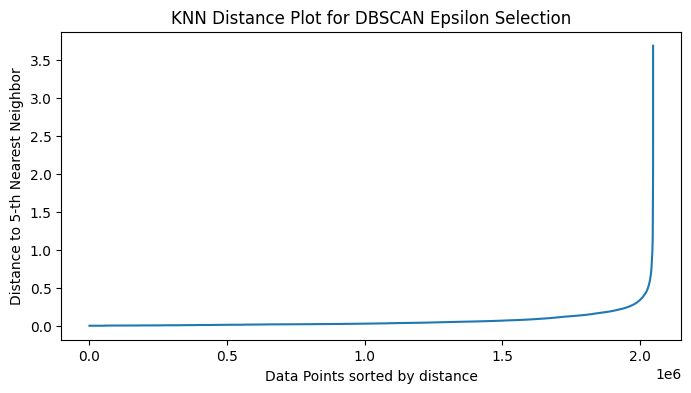

In [20]:
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

def plot_knn_distance(X, k=5):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)
    distances = np.sort(distances[:, k-1])  # k-th nearest neighbor distance

    plt.figure(figsize=(8, 4))
    plt.plot(distances)
    plt.xlabel("Data Points sorted by distance")
    plt.ylabel(f"Distance to {k}-th Nearest Neighbor")
    plt.title("KNN Distance Plot for DBSCAN Epsilon Selection")
    plt.show()

# Example: Run on the Household dataset
plot_knn_distance(X, k=5)

Notes on DBSCAN:

DBSCAN works well if clusters have different densities, has natural clusters within the data, and works best when we chose the most optimal epsilon value.

DBSCAN fails on high dimensional data, like on the 20NG dataset, it will also fail if our epsilon is too high because it will only makke one cluster. DBSCAN will also fail if our MinPts is too low because we will make a bunch of small clusters.

After attempting a brute force approach with 20NG and seeing an extremely high runtime, I have decided to implement some optimization to hopefully bring that runtime down.

Here is what I have done to optimize DBSCAN on real world data:


1.   Replaced brute force method with KD-Tree Nearest Neighbors
2.   Implemented PCA for 20NG to bring down features from 5,000 to 50
3.   Enabled GPU-Acceleration for Fashion-MNIST
4.   Normalization for household power consumption



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.datasets import fashion_mnist
import tensorflow as tf

# 🚀 Enable GPU Acceleration for Fashion-MNIST in Google Colab
tf.config.list_physical_devices('GPU')

# 📌 Define DBSCAN parameters for each dataset
dbscan_params = {
    "20NG": {"epsilon": 1.2, "minPts": 5},
    "Fashion-MNIST": {"epsilon": 5, "minPts": 10},
    "Household": {"epsilon": 0.8, "minPts": 5},
}

# 📌 Load and Preprocess 20 Newsgroups Data
print("Loading 20 Newsgroups dataset...")
newsgroups = fetch_20newsgroups(subset="all", remove=("headers", "footers", "quotes"))
vectorizer = TfidfVectorizer(max_features=5000)
X_20ng = vectorizer.fit_transform(newsgroups.data).toarray()

# Apply PCA to Reduce Dimensionality (5000 → 50)
print("Applying PCA to 20NG dataset...")
pca_20ng = PCA(n_components=50)
X_20ng_reduced = pca_20ng.fit_transform(X_20ng)

# Normalize the dataset
X_20ng_reduced = StandardScaler().fit_transform(X_20ng_reduced)

# 📌 Load and Preprocess Fashion-MNIST Data
print("Loading Fashion-MNIST dataset...")
(X_train, _), (_, _) = fashion_mnist.load_data()

# Flatten images and normalize
X_fashion = X_train.reshape(X_train.shape[0], -1) / 255.0

# 📌 Load and Preprocess Household Power Consumption Data
print("Loading Household Power Consumption dataset...")
household_data = pd.read_csv("household_power_consumption.csv")

# Drop missing values
household_data.dropna(inplace=True)

# Select numerical columns
features = ["Global_active_power", "Global_reactive_power", "Voltage",
            "Global_intensity", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]

X_household = household_data[features].values

# Normalize the dataset
X_household = StandardScaler().fit_transform(X_household)

# 📌 Custom DBSCAN Implementation (Optimized)
def dbscan(X, epsilon, minPts):
    """
    Optimized DBSCAN Implementation for clustering datasets.
    Uses efficient KD-Tree for neighbor search.
    """
    clusters = np.full(X.shape[0], -1)  # Initialize all points as noise (-1)
    cluster_id = 0

    # Use KD-Tree for fast nearest-neighbor search
    nn = NearestNeighbors(radius=epsilon, algorithm="kd_tree", n_jobs=-1)
    nn.fit(X)
    neighbors = nn.radius_neighbors(X, return_distance=False)

    # Function to expand a cluster
    def expand_cluster(point_idx, cluster_id):
        if len(neighbors[point_idx]) < minPts:
            return False  # Do not create a cluster
        else:
            clusters[point_idx] = cluster_id  # Assign to cluster
            queue = list(neighbors[point_idx])  # Expand from core point

            while queue:
                neighbor_idx = queue.pop()
                if clusters[neighbor_idx] == -1:  # Only update if still noise
                    clusters[neighbor_idx] = cluster_id
                    if len(neighbors[neighbor_idx]) >= minPts:
                        queue.extend(neighbors[neighbor_idx])  # Expand cluster

            return True

    # Process each point
    for i in range(X.shape[0]):
        if clusters[i] != -1:  # If already assigned, skip
            continue
        if expand_cluster(i, cluster_id):
            cluster_id += 1  # Create a new cluster

    return clusters

# 📌 Function to Run DBSCAN on a Given Dataset
def run_dbscan(X, dataset_name, epsilon, minPts):
    print(f"\nRunning DBSCAN on {dataset_name}...")

    # Run custom DBSCAN with optimized neighbor search
    clusters = dbscan(X, epsilon, minPts)

    # Count number of clusters
    num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    print(f"DBSCAN found {num_clusters} clusters in {dataset_name}")

    return clusters

# 📌 Run DBSCAN on Each Dataset
datasets = {
    "20NG": X_20ng_reduced,
    "Fashion-MNIST": X_fashion,
    "Household": X_household
}

for dataset_name, params in dbscan_params.items():
    run_dbscan(datasets[dataset_name], dataset_name, params["epsilon"], params["minPts"])


In [21]:
# Define DBSCAN parameters for each dataset
dbscan_params = {
    "20NG": {"epsilon": 1.2, "minPts": 5},
    "Fashion-MNIST": {"epsilon": 5, "minPts": 10},
    "Household": {"epsilon": 0.8, "minPts": 5},
}

# Run DBSCAN and visualize results
for dataset_name, params in dbscan_params.items():
    print(f"Running DBSCAN on {dataset_name}...")

    clusters = dbscan(X_20ng if dataset_name == "20NG" else
                      X_fashion if dataset_name == "Fashion-MNIST" else
                      X_household, params["epsilon"], params["minPts"])

    # Print number of clusters
    num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    print(f"Found {num_clusters} clusters in {dataset_name}")

Running DBSCAN on 20NG...


KeyboardInterrupt: 